# E-Commerce Sales Target's Brazilian Operations

### Analyzing this dataset offers valuable insights into Target's Brazilian operations, revealing details about order processing, pricing strategies, payment and shipping efficiency, customer demographics, product characteristics, and customer satisfaction. 

In [7]:
!pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

This code will help to load the data in MY-SQL faster, compare to directly importing to database. \
Note: the dataset is above 100mb in size.

In [108]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('order_items.csv', 'ordersitems'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('orders.csv','orders')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Qwer1234@',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'e:/DA/Projects ALL/Ecommerce/dataset'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm          

In [2]:

db = mysql.connector.connect( host ="localhost",
                             username="root",
                             password = "Qwer1234@",
                             database="ecommerce"
)
cur = db.cursor()


### 1. List all unique cities where customers are located.

In [4]:
query = """ select distinct customer_city from customers """
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=['Cities'])
df

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### 2. Count the number of orders placed in 2017.

In [5]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) =2017 """
cur.execute(query)

data = cur.fetchall()
"Total orders places in 2017 are",data[0][0] #return a tuple

('Total orders places in 2017 are', 45101)

### 3. Find the total sales per category.

In [13]:
query = """ 
SELECT upper(products.product_category) as category,
round(sum(payments.payment_value),2) as sales
FROM products 
    JOIN ordersitems 
    ON products.product_id = ordersitems.product_id

    JOIN payments
    ON payments.order_id = ordersitems.order_id

    GROUP BY category """

cur.execute(query)

data = cur.fetchall()
df  = pd.DataFrame(data,columns=['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### 4. Calculate the percentage of orders that were paid in installments.

In [18]:
query = """ 

SELECT (SUM(CASE WHEN payment_installments > 1 then 1 ELSE 0 END))/COUNT(*)*100 
FROM payments

"""

cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('49.4176'))

### 5. Count the number of customers from each state. 

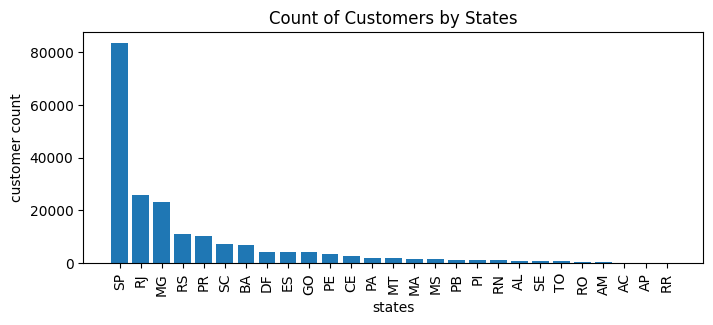

In [48]:
query = """ 

SELECT customer_state, COUNT(customer_id)
FROM customers 
GROUP BY customer_state

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns= ['State','Customers_count'])
df = df.sort_values(by="Customers_count", ascending= False)
plt.figure(figsize=(8,3))
plt.bar(df['State'],df['Customers_count'])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer count")
plt.title("Count of Customers by States")
plt.show()

### 6. Calculate the number of orders per month in 2018.

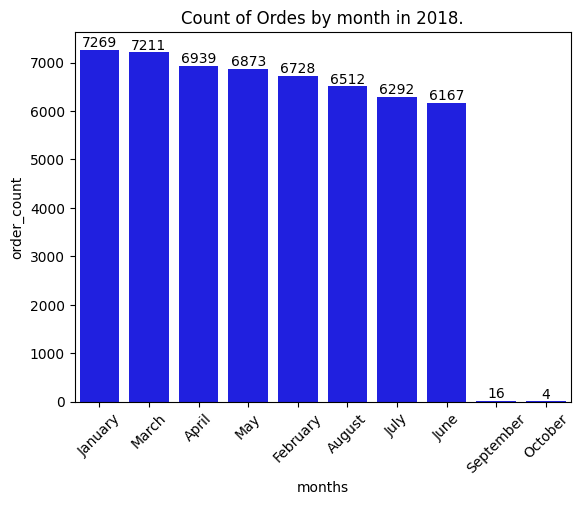

In [53]:
query = """ 

SELECT monthname(order_purchase_timestamp) months, COUNT(order_id) order_count
FROM orders 
WHERE year(order_purchase_timestamp) =2018 

GROUP BY months

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['months','order_count'])
df = df.sort_values(by="order_count", ascending= False)

ax = sns.barplot(x = df['months'],y = df['order_count'],data = df, color= 'blue')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Ordes by month in 2018.")
plt.show()

### 7. Find the average number of products per order, grouped by customer city.

In [60]:
query = """ 

with count_per_order as 
(select orders.order_id, orders.customer_id, count(ordersitems.order_id) oc
from orders join ordersitems
on orders.order_id = ordersitems.order_id
group by orders.order_id, orders.customer_id
)
select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city 
order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=['Customer City','Average product/order'])
df.head(10)

,Customer City,Average product/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,curralinho,4.00
7,picarra,4.00
8,morro de sao paulo,4.00
9,teixeira soares,4.00


### 8. Calculate the percentage of total revenue contributed by each product category.

In [66]:
query = """
SELECT upper(products.product_category) as category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales_percentage
FROM products 
    JOIN ordersitems 
    ON products.product_id = ordersitems.product_id

    JOIN payments
    ON payments.order_id = ordersitems.order_id

    GROUP BY category 
    ORDER BY sales_percentage desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['category','sales_percentage'])
df.head(5)

,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


### 9. Identify the correlation between product price and the number of times a product has been purchased.

In [78]:
query= """ 
select products.product_category, 
count(ordersitems.product_id),
round(avg(ordersitems.price),2) 
from products join ordersitems
on products.product_id = ordersitems.product_id
group by products.product_category;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['category','order_count','Avg price'])

arr1 = df['order_count']
arr2 = df['Avg price']
a = np.corrcoef([arr1,arr2])

print("the correalation between price and number of time the product is purchase", a[0][-1])

the correalation between price and number of time the product is purchase -0.10631514167157562


### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

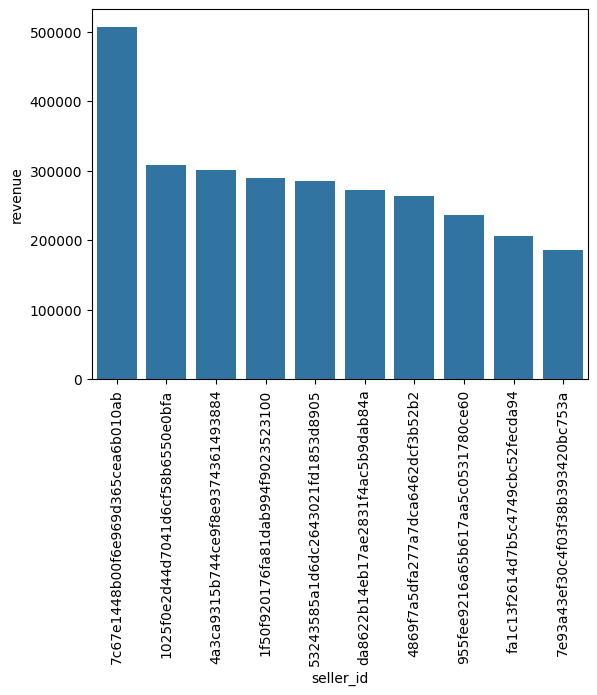

In [86]:
query =""" 
select * , dense_rank() over(order by revenue desc) as rn from 
(select ordersitems.seller_id,sum(payments.payment_value) as revenue 
from ordersitems join payments
on ordersitems.order_id = payments.order_id
group by ordersitems.seller_id) as a
  """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['seller_id','revenue','rank'])
df = df.head(10)
sns.barplot(x= 'seller_id',y= 'revenue',data = df)
plt.xticks(rotation = 90)
plt.show()



### 11. Calculate the moving average of order values for each customer over their order history.

In [88]:
query = """  
select customer_id, order_purchase_timestamp, payment,
 avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a;
  """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


### 12. Calculate the cumulative sales per month for each year.

In [92]:
query = """    select years, months, payment,sum(payment)
over(order by years, months) cumulative_sales from 

(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from orders 
join payments
on orders.order_id = payments.order_id
group by years,months
order by years, months) as a;
  """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Year','Month','Sales','Cumultive sales'])
df.head(12)

,Year,Month,Sales,Cumultive sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### 13. Calculate the year-over-year growth rate of total sales.

,Years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


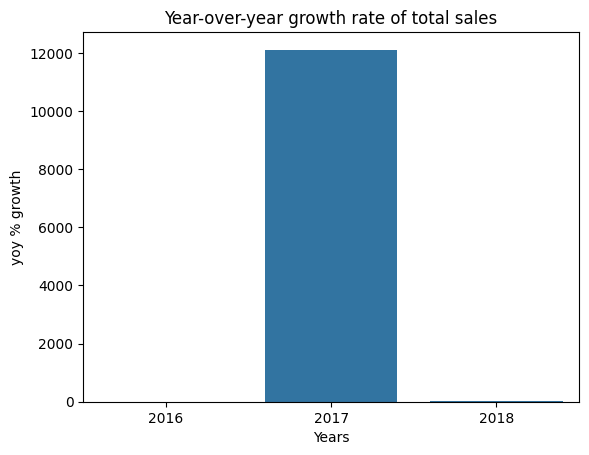

In [116]:
query = """ 
with a as
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from orders 
join payments
on orders.order_id = payments.order_id
group by years
order by years) 
select years, ((payment - lag(payment, 1) over(order by years))/ 
lag(payment, 1) over(order by years) )  * 100 from a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Years','yoy % growth'])
sns.barplot(x= 'Years', y = 'yoy % growth', data =df )
plt.title("Year-over-year growth rate of total sales")
df

### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [100]:
query = """ 
with a as(
select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers 
join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp > date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id)) 
from a left join b
on a.customer_id = b.customer_id ;

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,)
df
# no retantion customer

,0
0,None


### 15. Identify the top 3 customers who spent the most money in each year.

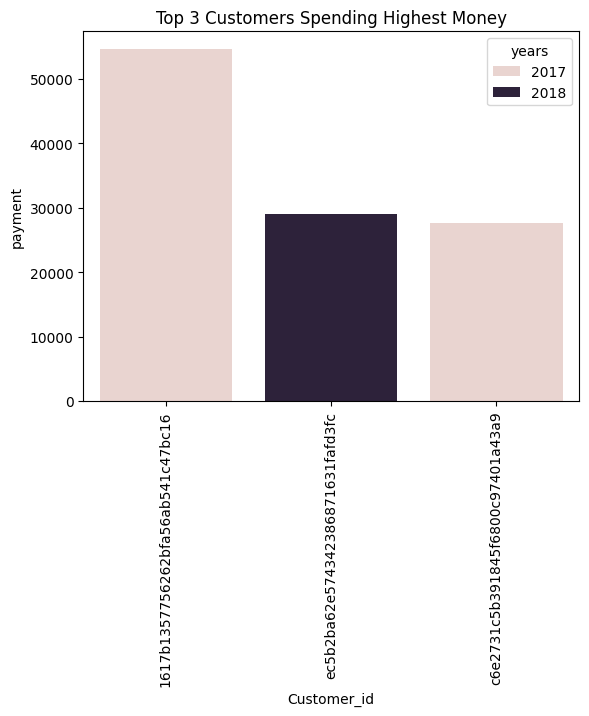

In [124]:
query = """ select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a 
where d_rank <=3  """

cur.execute(query)
data = cur.fetchall()
#df = df.head(3)
df = pd.DataFrame(data,columns=['years','Customer_id','payment','rank']).sort_values(by = 'payment',ascending=False)
df = df.head(3)
sns.barplot(x= 'Customer_id', y = 'payment',data =df, hue  = 'years' )
plt.title("Top 3 Customers Spending Highest Money")
plt.xticks(rotation  =90)
plt.show()